<a href="https://colab.research.google.com/github/Olubusolami-R/gaussian-processes-cw/blob/main/2526/cw1/coursework1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Ensure correct environment for GPy
import numpy, os, signal
if numpy.__version__ != "1.26.4":
    # 1. Uninstall conflicting packages
    !pip uninstall -y jax scipy jaxlib paramz pytensor > /dev/null 2>&1
    # 2. Install the versions required for GPy
    !pip install --force-reinstall numpy==1.26.4 scipy GPy paramz > /dev/null 2>&1
    # 3. Restart runtime to load correct NumPy ABI
    os.kill(os.getpid(), signal.SIGKILL)

!wget -q https://mlg.eng.cam.ac.uk/teaching/4f13/2526/cw/cw1a.mat > /dev/null
!wget -q https://mlg.eng.cam.ac.uk/teaching/4f13/2526/cw/cw1e.mat > /dev/null
!wget -q https://raw.githubusercontent.com/cambridge-mlg/4f13-courseworks/refs/heads/main/2526/cw1/gp.py > /dev/null

In [2]:
import GPy
import numpy as np
import gp as cw1utils

In [3]:
### Arbitrary data, X and y
X = np.random.rand(20, 1) * 10  # 20 data points in 1D
y = np.sin(X) + (np.cos(X))**2 + np.random.randn(20, 1) * 0.5  # noisy opipbservations

## Loading Matlab arrays in Python

In [4]:
import scipy.io as sio

In [5]:
data = sio.loadmat("cw1a.mat")  # Note this will throw an error because the file does not exist!

X = np.asarray(data["x"], dtype=float)
y = np.asarray(data["y"], dtype=float)

## GP Model Definition with Various Kernels (using GPy):

### Single kernels

Squared exponential (SE) isotropic

In [6]:
k = GPy.kern.RBF(input_dim=X.shape[1], lengthscale=1.0, variance=1.0)
m = GPy.models.GPRegression(X, y, k)
m.likelihood.variance = 1.0  # Note that this is the default value, so we don't strictly need to set it here unless we want a different initial value.

Periodic

In [7]:
k = GPy.kern.StdPeriodic(input_dim=X.shape[1], lengthscale=1.0, period=1.0, variance=1.0)
m = GPy.models.GPRegression(X, y, k)

SE Automatic Relevance Determination (ARD)

In [8]:
k = GPy.kern.RBF(input_dim=X.shape[1], ARD=True, lengthscale=1.0, variance=1.0)
m = GPy.models.GPRegression(X, y, k)

### Combined kernels

Product of Periodic and SE Isotropic

In [9]:
k_per = GPy.kern.StdPeriodic(input_dim=X.shape[1], lengthscale=1.0, period=1.0, variance=1.0)
k_se  = GPy.kern.RBF(input_dim=X.shape[1], lengthscale=1.0, variance=1.0)
kernel = k_per * k_se
m = GPy.models.GPRegression(X, y, kernel)

Sum of two SE ARD Kernels

In [10]:
z = np.random.randn(4)
ell1 = np.exp(z[0])
sf1  = np.exp(z[1])
var1 = sf1**2

ell2 = np.exp(z[2])
sf2  = np.exp(z[3])
var2 = sf2**2

k1 = GPy.kern.RBF(input_dim=X.shape[1], ARD=True, lengthscale=ell1, variance=var1)
k2 = GPy.kern.RBF(input_dim=X.shape[1], ARD=True, lengthscale=ell2, variance=var2)
k  = k1 + k2

m = GPy.models.GPRegression(X, y, kernel=k)

## GP Model Hyperparameter Optimisation using Marginal Likelihood

Once a GP regression model is specified, we can optimise its hyperparameters by minimising the negative log marginal likelihood (which is equivalent to maximising the likelihood of the data under the model.)

In [11]:
m.optimize(optimizer='lbfgsb', max_iters=2000, messages=False)

## Utilities functions useful for producing figures to be included in report

MODEL SUMMARY
NEGATIVE LOG MARGINAL LIKELIHOOD: 78.2202
OPTIMISED HYPERPARAMETERS:
    Component 1:
      • lengthscale (ℓ): 8.04214
      • signal std (σ_f): 0.69596
    Component 2:
      • lengthscale (ℓ): 13.9295
      • signal std (σ_f): 0.00225131
    Noise std (σ_n): 0.663068
LML: -78.220188
  • Data fit term: -37.500265
  • Complexity penalty: -28.200467
  • Constant term: -68.920390


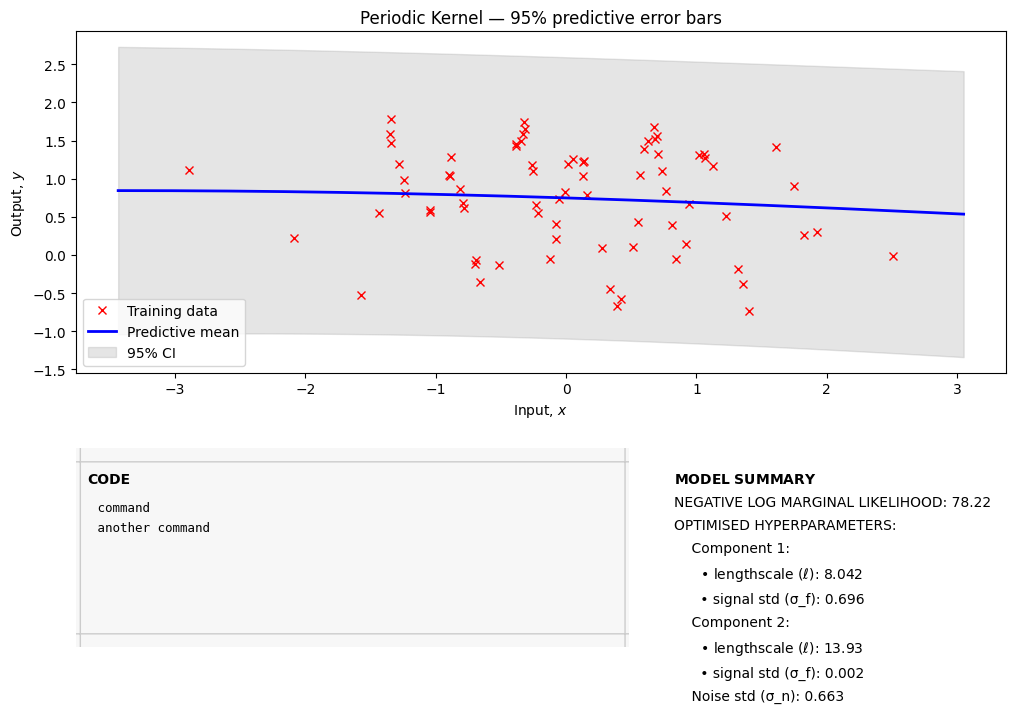

In [12]:
cw1utils.print_model_summary(m)
cw1utils.print_model_marginal_likelihood(m)
cw1utils.plot_predictive_error_bars(m, X, y, "\n command\n another command")

# cw1utils.plot_2d_predictive(mA, mB, codeA=None, codeB=None, save_path=None)
# cw1utils.plot_sampled_functions(X, F, code_snippet, n_draws=3, save_path=None)

# Now to the questions

# Question A

In [13]:
# loading the data

data = sio.loadmat("cw1a.mat")

X = np.asarray(data["x"], dtype=float)
y = np.asarray(data["y"], dtype=float)

#  Train a GP with a squared exponential covariance function, GPy.kern.RBF() and intialise the hyper parameters as described.

k = GPy.kern.RBF(input_dim=X.shape[1], lengthscale=np.exp(-1.0), variance=1.0)
m = GPy.models.GPRegression(X, y, k)

m.Gaussian_noise.variance = 1.0

In [14]:
m.optimize()

In [15]:
print(m)


Name : GP regression
Objective : 11.899004246684939
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |    0.8045956274095476  |      +ve      |        
  rbf.lengthscale          |   0.12822652660430478  |      +ve      |        
  Gaussian_noise.variance  |  0.013883389223900876  |      +ve      |        


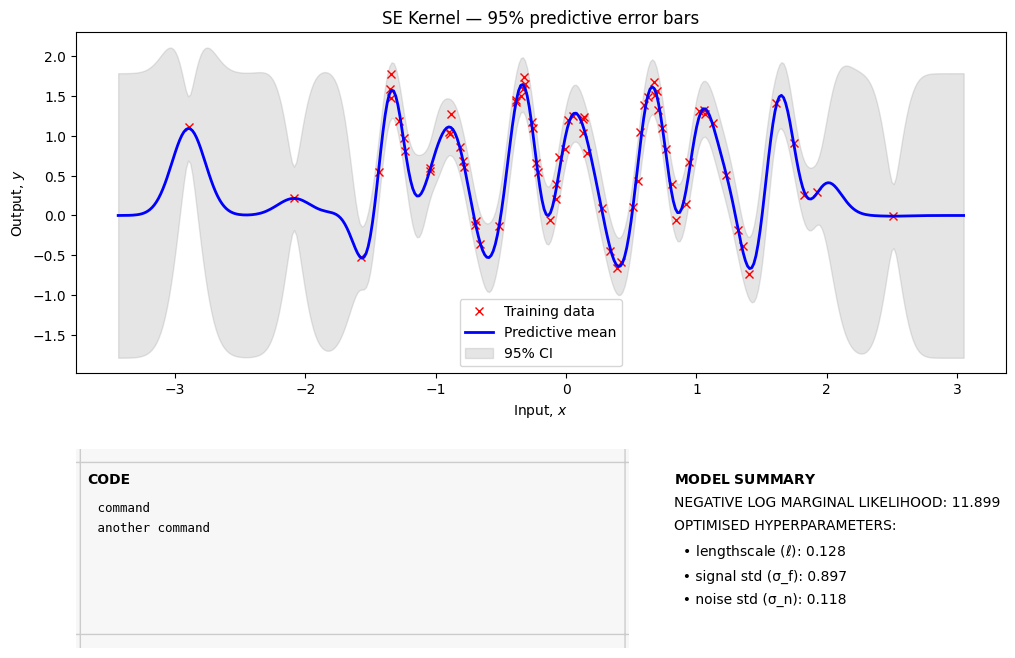

In [16]:
cw1utils.plot_predictive_error_bars(m, X, y, "\n command\n another command")

## Some preliminary observations for this part a

## Analysing the optimised params:
---

- lengthscale: This is a very small value relative to the input range.
- The model now assumes points only a small distance apart are highly correlated. This allows the model to produce a highly oscillating or "wiggly" function that accurately tracks the rapid variations in the data.
- Low noise estimate: The model believes the data is relatively clean and the wiggles are true signal, not just noise. It therefore attempts to pass very closely to the majority of the data points.
- This value (variance $\sigma_f^2 \approx 0.805$) is close to the vertical range of the wiggles.Consequence: It confirms the magnitude of the smooth variations that the function makes.

- Narrow Bands Near Data (Interpolation): The shaded area is tightly constrained around the predictive mean (blue line) where the training data (red crosses) exists. This narrowness is due to the low noise estimate ($\sigma_n \approx 0.118$), showing high confidence in the function's value near observed points.
- The small optimized lengthscale ($\ell=0.128$) implies that the function must be highly wiggly. This is clearly demonstrated by the predictive error bars, which are extremely narrow directly around the data points (due to the low noise $\sigma_n$), but rapidly widen in any region devoid of data (e.g., $x \approx -2.5$ and $x>2.0$), because the model instantly loses correlation just a short distance away from the observations.
- Uncertainty Spikes in Extrapolation: In the regions far outside the data (e.g., $x>2.5$ or $x<-3.0$), the uncertainty quickly reaches the maximum level defined by the Signal Standard Deviation, confirming the model has no idea what happens far outside the training range.


## Mental Cheatsheet
- **Lengthscale (l)**: small value - wiggly fxn, quickly changing. High value - Smooth function, slow to change. low l is typically less than input range. high l is higher than input range.

- **Noise Variance ($\sigma_n^2$) (The Cleanliness Measure):** The Noise Variance is compared to the Signal Variance ($\sigma_f^2$) itself, as it defines the signal-to-noise ratio. Low $\sigma_n^2$ that is $\sigma_n^2 \ll \sigma_f^2$ means *the data is believed to be clean*. The model trusts the data points and tries to fit them tightly, resulting in narrow error bars at the data points. For $\sigma_n^2 \approx \sigma_f^2$ or $\sigma_n^2 > \sigma_f^2$, The data is believed to be noisy. The model is forced to smooth over the points, and the uncertainty remains high everywhere. *In summary, if low, data is clean; model fits points tightly. If high, data is noisy; model smooths over the points.*

- **Signal variance**: If it is low, function is flat. If it is high, function has large vertical swings.

# Question B


In [17]:
print(m)


Name : GP regression
Objective : 11.899004246684939
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |    0.8045956274095476  |      +ve      |        
  rbf.lengthscale          |   0.12822652660430478  |      +ve      |        
  Gaussian_noise.variance  |  0.013883389223900876  |      +ve      |        


In [34]:
m.optimize_restarts(num_restarts=20, verbose=True)

Optimization restart 1/20, f = 11.899004246587026
Optimization restart 2/20, f = 11.899004246633545
Optimization restart 3/20, f = 78.22018817433874
Optimization restart 4/20, f = 78.2201881729653
Optimization restart 5/20, f = 78.22018817340978
Optimization restart 6/20, f = 11.899004246587182
Optimization restart 7/20, f = 78.22018817382607
Optimization restart 8/20, f = 11.899004246587936
Optimization restart 9/20, f = 78.22018817395235
Optimization restart 10/20, f = 78.22018817421335
Optimization restart 11/20, f = 78.22018817803318
Optimization restart 12/20, f = 78.22018818236901
Optimization restart 13/20, f = 78.22018817296563
Optimization restart 14/20, f = 78.22018817297518
Optimization restart 15/20, f = 11.899004246586983
Optimization restart 16/20, f = 78.22018817296572
Optimization restart 17/20, f = 78.22018817313086
Optimization restart 18/20, f = 78.22018967278116
Optimization restart 19/20, f = 78.22018817298792
Optimization restart 20/20, f = 11.899004246600839


In [35]:
print(m)


Name : GP regression
Objective : 11.899004246586983
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |   0.8045924565317458  |      +ve      |        
  rbf.lengthscale          |  0.12822637723530653  |      +ve      |        
  Gaussian_noise.variance  |   0.0138834054988376  |      +ve      |        



--- Model B: Local Optimum ---

Name : GP regression
Objective : 78.22018817299701
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |   0.4843418702065867  |      +ve      |        
  rbf.lengthscale          |     8.04193964876358  |      +ve      |        
  Gaussian_noise.variance  |  0.43966291862648554  |      +ve      |        


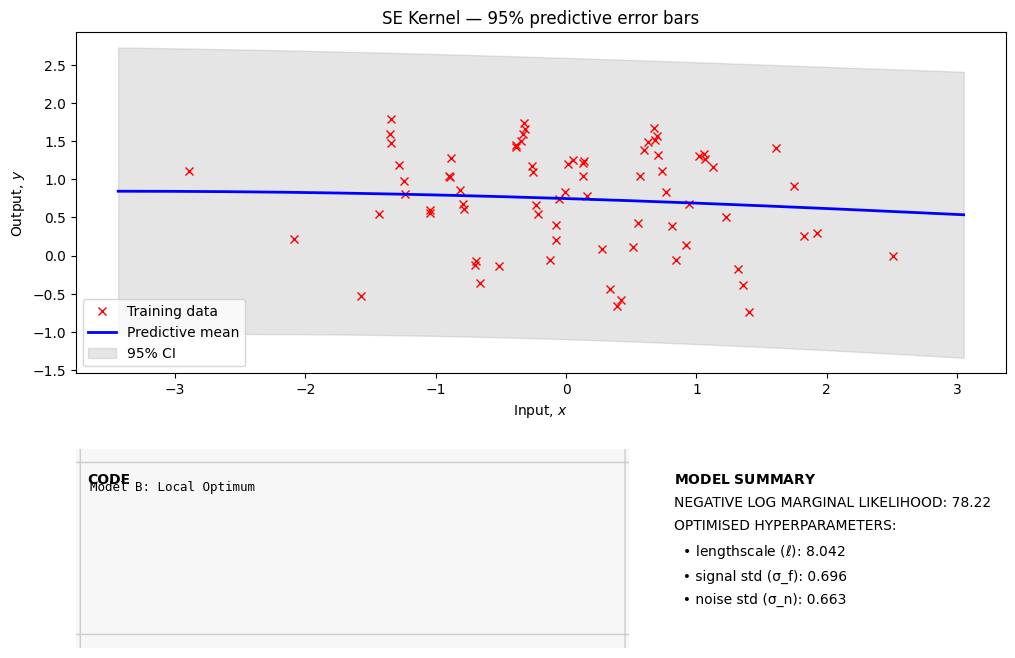

In [40]:
# Model B is the Local Optimum (NLML ≈ 78.220)

# 1. Define a NEW model (m_local) and initialize to the "smooth" basin
k_local = GPy.kern.RBF(input_dim=X.shape[1], variance=1.0, lengthscale=10.0)
m_local = GPy.models.GPRegression(X, y, k_local)
m_local.Gaussian_noise.variance = 10.0

m_local.optimize()

# 3. Print the final hyperparameters and NLML (Should show NLML ≈ 78.220)
print("\n--- Model B: Local Optimum ---")
print(m_local)

# 4. Plot the poor fit (Smooth/Noisy interpretation)
# This plot shows the flat mean function and wide, constant error bars.
cw1utils.plot_predictive_error_bars(m_local, X, y, "Model B: Local Optimum")

Potential answers
---

Multiple optimization restarts confirmed the existence of two distinct local optima. Specifically, when initializing the hyperparameters to find the Smooth/Noisy Optimum (Optimum B), we observed that the Negative Log Marginal Likelihood (NLML) consistently converged to $\mathbf{78.220}$, even with varied initial values for the kernel variance ($\sigma_f^2$) and noise variance ($\sigma_n^2$).

For 78.22: "This stability is due to the very large initial lengthscale ($\ell=10.0$) dominating the model's interpretation. A large lengthscale locks the model into the assumption that the underlying function is extremely smooth (i.e., almost flat). Once committed to this smooth structure, the optimization problem simplifies. The optimizer merely finds the optimal ratio between $\sigma_f^2$ and $\sigma_n^2$ necessary to account for the data scatter under that fixed, smooth assumption. This local minimum is a very wide and shallow valley in the NLML landscape, making it easy to find and highly stable, regardless of the initial variance settings."

For 11.899: In contrast, the Global Optimum (A), with $\text{NLML} \approx 11.899$, requires the lengthscale to be optimized to a very small value ($\ell \approx 0.128$). This optimal NLML region is much sharper and harder to find, which is why the initial configuration of $\ell=e^{-1}$ only sometimes lands there, leading to a much greater $\Delta \text{NLML}$ and high confidence in its superiority.

# Question C

In [47]:
k = GPy.kern.StdPeriodic(input_dim=X.shape[1], lengthscale=1, period=1.0, variance=1.0)
m = GPy.models.GPRegression(X, y, k)

In [48]:
m.optimize()

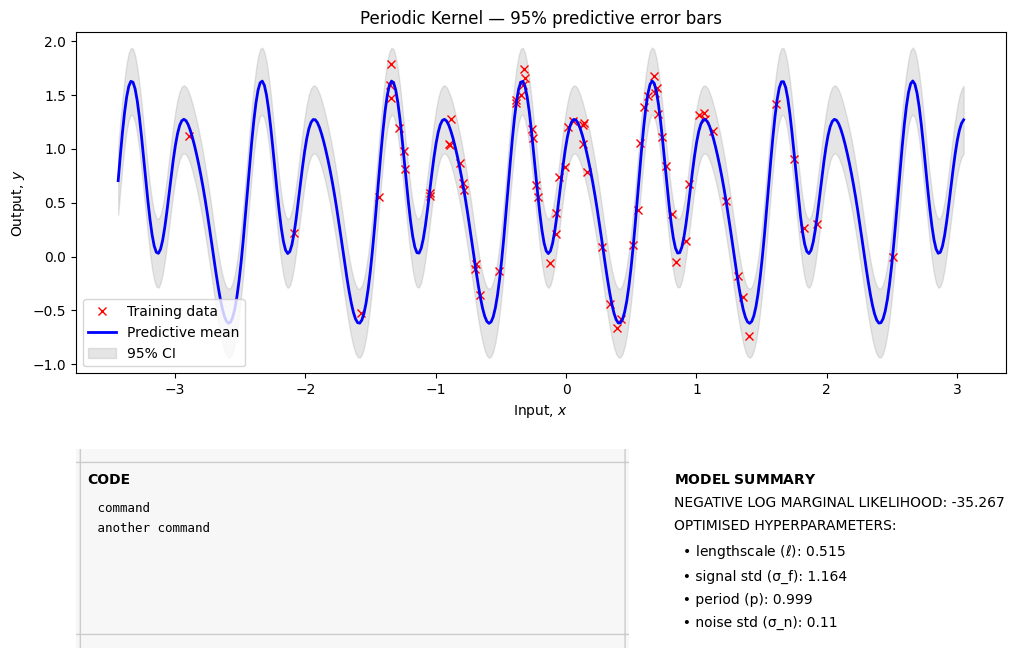

In [49]:
cw1utils.plot_predictive_error_bars(m, X, y, "\n command\n another command")

## Potential answer
---

The evidence overwhelmingly supports the conclusion that the underlying data-generating function is strictly periodic in nature.

1. Quantitative Evidence (Model Selection): The most compelling evidence comes from the Negative Log Marginal Likelihood (NLML), which is the gold standard for model comparison:RBF (Smooth/Wiggly) NLML: $11.899$ Periodic NLML: $\mathbf{-35.267}$ The difference, $\Delta \text{NLML} \approx 47.166$, is a massive reduction. This tells us the periodic assumption provides a vastly superior and simpler explanation of the data's structure. If the data were only "quasi-periodic" (just generally wiggling), the flexible RBF kernel would likely have achieved a much closer NLML score. The fact that the strictly defined Periodic kernel wins so decisively proves the repeating pattern is highly regular.

2. Hyperparameter Evidence: The optimized hyperparameters confirm the strictness of the pattern:Clean Period ($p$): The model optimized the period to $\mathbf{0.999}$. This is almost mathematically equal to $1.0$, indicating the spacing of the wiggles is extremely regular and consistent across the entire input domain.Low Noise ($\sigma_n$): The final noise standard deviation of $\mathbf{0.110}$ means the model assumes very little error is left over after fitting the periodic function. The remaining error is attributed only to minor observation noise, not to failures in the periodic structure itself.

3. Qualitative Evidence (Error Bars): The behavior of the predictive error bars qualitatively validates the periodic assumption:The uncertainty band is narrow everywhere it is constrained by the fitted function.Crucially, in the extrapolation regions (e.g., $x>2.5$), the predictive mean continues the oscillation indefinitely, and the uncertainty remains low. This demonstrates the model's high confidence that the pattern repeats exactly into unobserved territory, which is the very definition of a strictly periodic function.

4. Conclusion: The combination of a highly regular optimized period ($p \approx 1.0$) and the overwhelming statistical preference for the Periodic model ($\text{NLML} = -35.267$) provides conclusive evidence that the data-generating mechanism, apart from noise, is strictly periodic.

# Question D